## Classical noising, fully quantum simple U-Net ##

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import h5py
import scipy.linalg

filename = "C:/Users/realc/OneDrive/Documents/GSOC/data/QG3_normalized_16_xl"
data_X = np.array(h5py.File(filename, "r")['X'])

def scramble_state_vectors(encoded_data, seed):
    np.random.seed(seed)
    scrambled_vectors = []
    for i in range(len(encoded_data)):
        # scrambled_state = np.random.permutation(encoded_data[i].flatten())
        gaussian_matrix = np.random.normal(0, 0.1, (16, 16))
        scrambled_state = np.multiply(gaussian_matrix, encoded_data[i])
        scrambled_vectors.append(scrambled_state)
    return np.array(scrambled_vectors).reshape(len(encoded_data), 8, 8, 4)

def reshape_scrambled_states(scrambled_states):
    reshaped_scrambled_states = scrambled_states.reshape(scrambled_states.shape[0], 8, 8, 4)
    return reshaped_scrambled_states

def visualize_data(original_data, encoded_data, sample_index=0):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(original_data[sample_index], cmap='viridis')
    axes[0].set_title("Original Data")
    
    axes[1].imshow(encoded_data[sample_index], cmap='viridis')
    axes[1].set_title("AAA Data")
    
    plt.tight_layout()
    plt.show()

class ClassicalDiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ClassicalDiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_dim = 8 * 8 * 4
hidden_dim = 128
output_dim = 8 * 8 * 4

model = ClassicalDiffusionModel(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_samples = 1000
num_epochs = 10
loss_values = []

scrambled_states = scramble_state_vectors(data_X[:num_samples], seed=42)
scrambled_states = torch.tensor(scrambled_states, dtype=torch.float32).view(num_samples, -1)
encoded_data = torch.tensor(data_X[:num_samples], dtype=torch.float32).view(num_samples, -1)


Epoch [1/50], Loss: 0.0164
Epoch [2/50], Loss: 0.0103
Epoch [3/50], Loss: 0.0084
Epoch [4/50], Loss: 0.0083
Epoch [5/50], Loss: 0.0080
Epoch [6/50], Loss: 0.0071
Epoch [7/50], Loss: 0.0061
Epoch [8/50], Loss: 0.0055
Epoch [9/50], Loss: 0.0053
Epoch [10/50], Loss: 0.0052
Epoch [11/50], Loss: 0.0052
Epoch [12/50], Loss: 0.0050
Epoch [13/50], Loss: 0.0048
Epoch [14/50], Loss: 0.0046
Epoch [15/50], Loss: 0.0044
Epoch [16/50], Loss: 0.0043
Epoch [17/50], Loss: 0.0043
Epoch [18/50], Loss: 0.0042
Epoch [19/50], Loss: 0.0042
Epoch [20/50], Loss: 0.0042
Epoch [21/50], Loss: 0.0041
Epoch [22/50], Loss: 0.0041
Epoch [23/50], Loss: 0.0041
Epoch [24/50], Loss: 0.0041
Epoch [25/50], Loss: 0.0040
Epoch [26/50], Loss: 0.0040
Epoch [27/50], Loss: 0.0040
Epoch [28/50], Loss: 0.0040
Epoch [29/50], Loss: 0.0040
Epoch [30/50], Loss: 0.0040
Epoch [31/50], Loss: 0.0040
Epoch [32/50], Loss: 0.0040
Epoch [33/50], Loss: 0.0039
Epoch [34/50], Loss: 0.0039
Epoch [35/50], Loss: 0.0039
Epoch [36/50], Loss: 0.0039
E

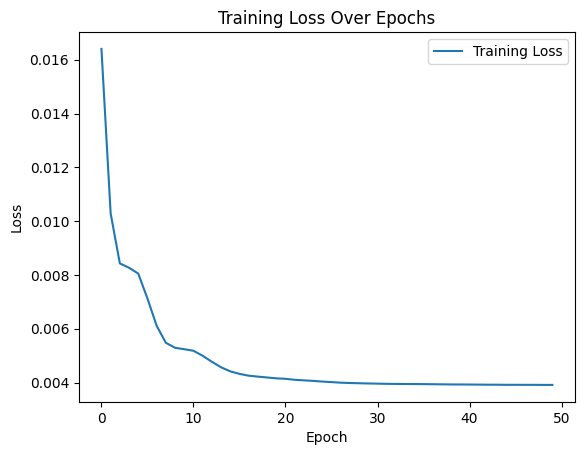

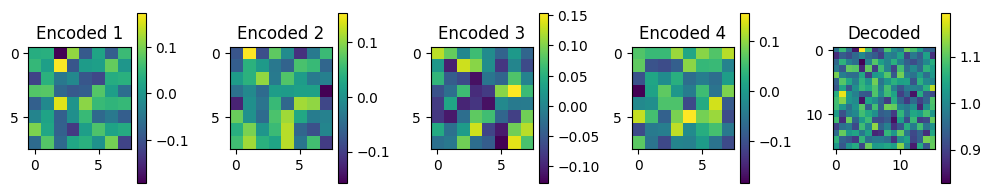

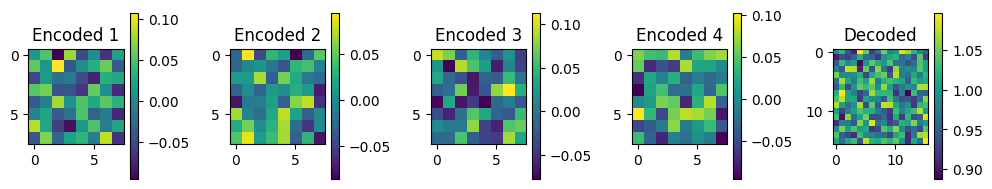

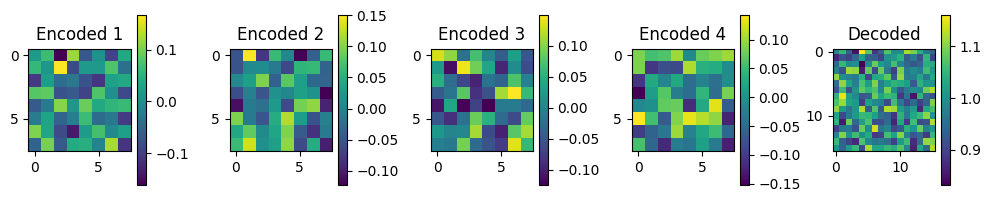

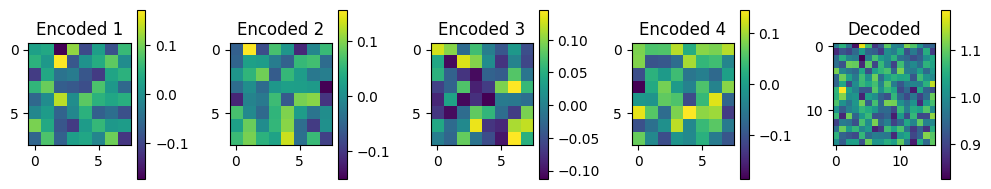

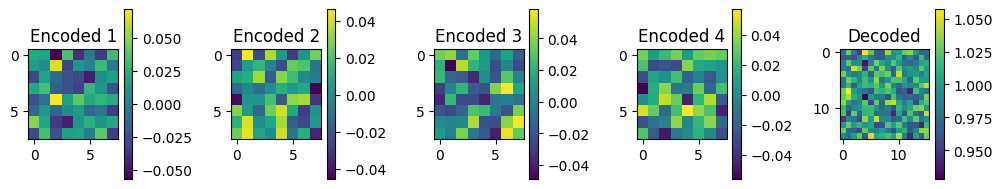

In [6]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Setting up the quantum device
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum circuit with the correct decorator
@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Convert the quantum circuit to a Torch layer
class QuantumLayer(nn.Module):
    def __init__(self, n_qubits, n_layers):
        super(QuantumLayer, self).__init__()
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes)

    def forward(self, x):
        return self.qlayer(x)

# Define the Quantum Diffusion Model using the quantum layer
class QuantumDiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits, n_layers):
        super(QuantumDiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, n_qubits)
        self.quantum_layer = QuantumLayer(n_qubits, n_layers)
        self.fc2 = nn.Linear(n_qubits, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.quantum_layer(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Parameters for the quantum model
n_layers = 6

# Instantiate the quantum model
model = QuantumDiffusionModel(input_dim, hidden_dim, output_dim, n_qubits, n_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training the model
loss_values = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(scrambled_states)
    loss = criterion(outputs, encoded_data)
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plotting the training loss
plt.plot(loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

def flip(decoded_data):
    return 1 - decoded_data

def decode(encoded_data):
    num_samples, encoded_height, encoded_width, num_channels = encoded_data.shape
    decoded_data = np.zeros((num_samples, 16, 16))

    for sample in range(num_samples):
        for i in range(encoded_height):
            for j in range(encoded_width):
                for c in range(num_channels):
                    if c == 0:
                        decoded_data[sample, 2*i, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 1:
                        decoded_data[sample, 2*i, 2*j+1] = encoded_data[sample, i, j, c]
                    elif c == 2:
                        decoded_data[sample, 2*i+1, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 3:
                        decoded_data[sample, 2*i+1, 2*j+1] = encoded_data[sample, i, j, c]

    return decoded_data

def generate_new_images(model, num_images, input_dim=8*8*4):
    model.eval()
    with torch.no_grad():
        random_noise = torch.randn(num_images, input_dim)
        generated_data = model(random_noise)
        generated_data = generated_data.view(num_images, 8, 8, 4).detach().numpy()
        decoded_images = flip(decode(generated_data))
        
        for i in range(num_images):
            fig, axes = plt.subplots(1, 5, figsize=(10, 2))
            for qubit in range(4):
                im = axes[qubit].imshow(generated_data[i, :, :, qubit], cmap='viridis')
                axes[qubit].set_title(f"Encoded {qubit+1}")
                fig.colorbar(im, ax=axes[qubit])
            im = axes[4].imshow(decoded_images[i], cmap='viridis')
            axes[4].set_title("Decoded")
            fig.colorbar(im, ax=axes[4])
            plt.tight_layout()
            plt.show()
    return decoded_images


num_samples_to_generate = 5
new_images = generate_new_images(model, num_samples_to_generate)


Epoch [1/50], Loss: 0.0039, Val Loss: 0.0038, FID: 252.8922
Epoch [2/50], Loss: 0.0039, Val Loss: 0.0038, FID: 252.8846
Epoch [3/50], Loss: 0.0039, Val Loss: 0.0038, FID: 252.8786
Epoch [4/50], Loss: 0.0039, Val Loss: 0.0038, FID: 252.8743
Epoch [5/50], Loss: 0.0039, Val Loss: 0.0038, FID: 252.8705
Epoch [6/50], Loss: 0.0039, Val Loss: 0.0038, FID: 252.8680
Epoch [7/50], Loss: 0.0039, Val Loss: 0.0038, FID: 252.8674
Epoch [8/50], Loss: 0.0039, Val Loss: 0.0038, FID: 252.8687
Epoch [9/50], Loss: 0.0039, Val Loss: 0.0038, FID: 252.8726
Epoch [10/50], Loss: 0.0039, Val Loss: 0.0038, FID: 252.8788
Epoch [11/50], Loss: 0.0039, Val Loss: 0.0039, FID: 252.8864
Epoch [12/50], Loss: 0.0039, Val Loss: 0.0039, FID: 252.8953
Epoch [13/50], Loss: 0.0039, Val Loss: 0.0039, FID: 252.9057
Epoch [14/50], Loss: 0.0039, Val Loss: 0.0039, FID: 252.9165
Epoch [15/50], Loss: 0.0039, Val Loss: 0.0039, FID: 252.9264
Epoch [16/50], Loss: 0.0039, Val Loss: 0.0039, FID: 252.9357
Epoch [17/50], Loss: 0.0039, Val 

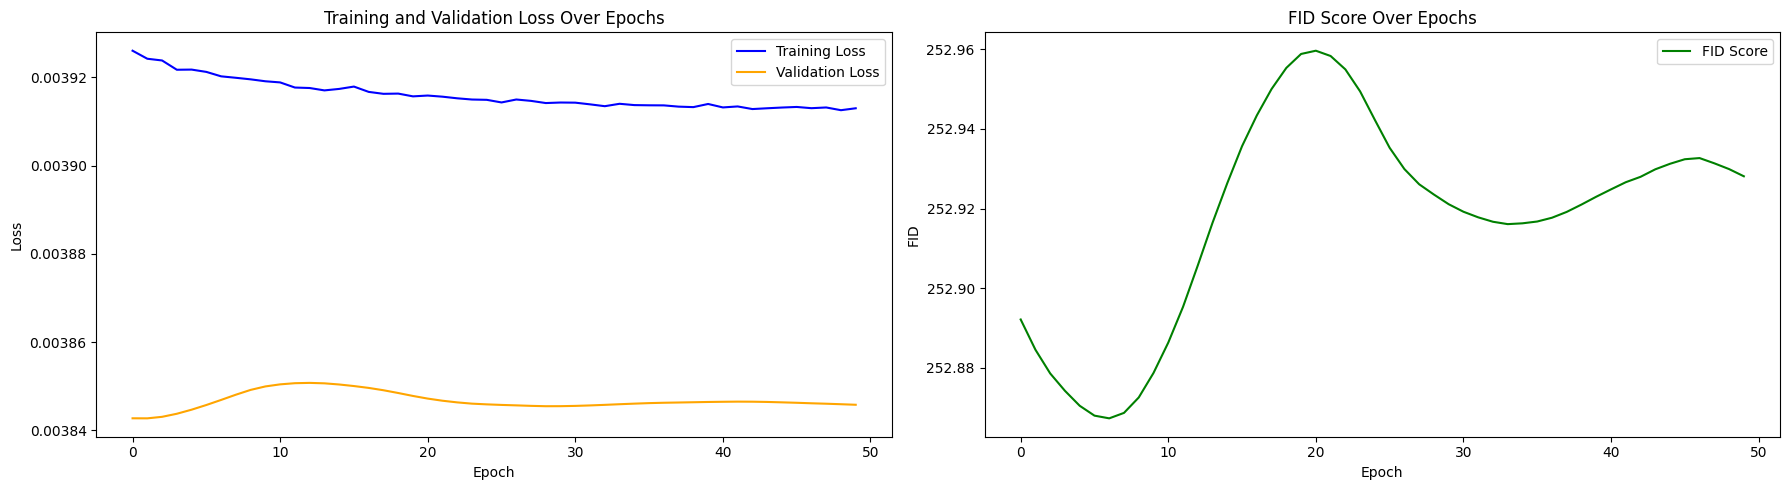

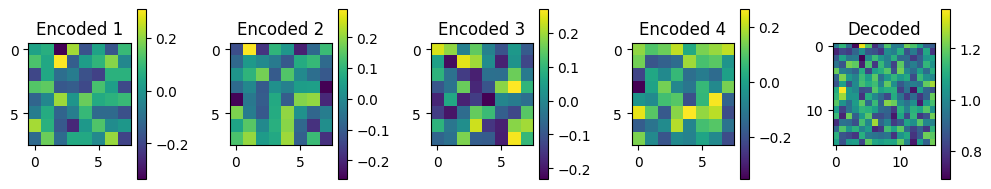

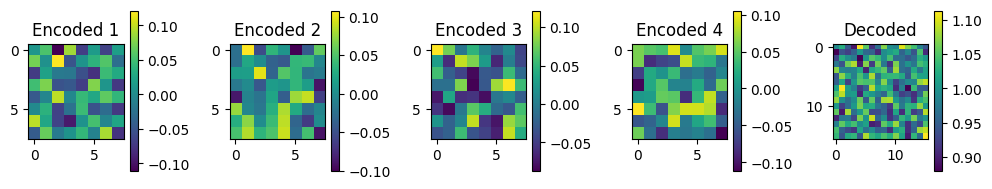

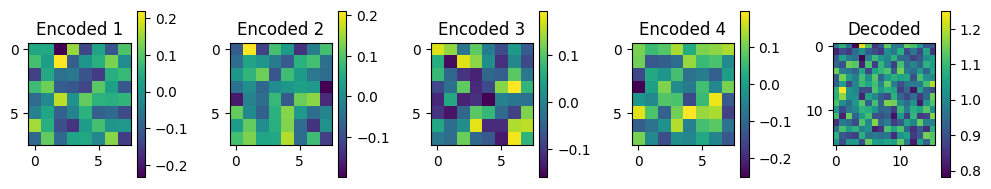

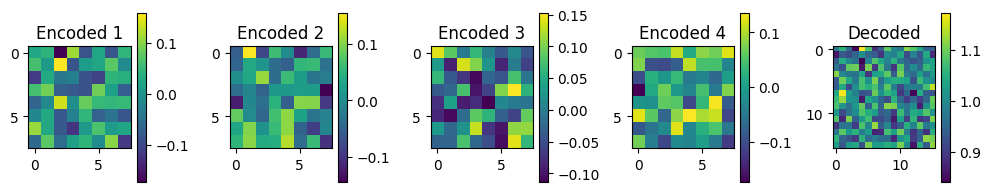

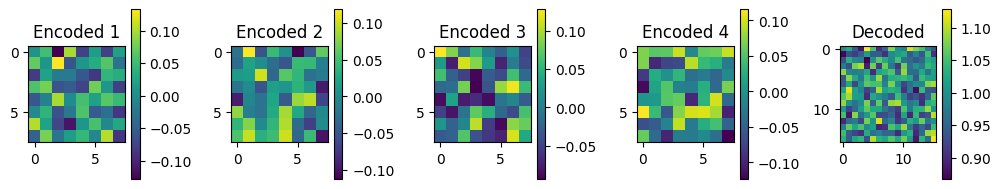

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy.linalg

# Assuming data_X is already loaded as you described before
train_encoded_data, val_encoded_data, train_scrambled_states, val_scrambled_states = train_test_split(
    encoded_data, scrambled_states, test_size=0.2, random_state=42, shuffle=True
)

# Quantum Diffusion Model architecture
class QuantumDiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_qubits, n_layers):
        super(QuantumDiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, n_qubits)
        self.quantum_layer = QuantumLayer(n_qubits, n_layers)
        self.fc2 = nn.Linear(n_qubits, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.quantum_layer(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Function to decode the scrambled data back to original format
def decode(encoded_data):
    num_samples, encoded_height, encoded_width, num_channels = encoded_data.shape
    decoded_data = np.zeros((num_samples, 16, 16))

    for sample in range(num_samples):
        for i in range(encoded_height):
            for j in range(encoded_width):
                for c in range(num_channels):
                    if c == 0:
                        decoded_data[sample, 2*i, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 1:
                        decoded_data[sample, 2*i, 2*j+1] = encoded_data[sample, i, j, c]
                    elif c == 2:
                        decoded_data[sample, 2*i+1, 2*j] = encoded_data[sample, i, j, c]
                    elif c == 3:
                        decoded_data[sample, 2*i+1, 2*j+1] = encoded_data[sample, i, j, c]

    return decoded_data

def flip(decoded_data):
    return 1 - decoded_data

# Function to calculate mean and covariance statistics
def calculate_statistics(data):
    data = data.reshape(data.shape[0], -1)  # flatten images
    mean = np.mean(data, axis=0)
    covariance = np.cov(data, rowvar=False)
    return mean, covariance

# Function to calculate FID
def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    diff = mu1 - mu2
    covmean, _ = scipy.linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = diff @ diff + np.trace(sigma1) + np.trace(sigma2) - 2 * np.trace(covmean)
    return fid

# Training the quantum model
num_epochs = 50
loss_values = []
val_loss_values = []
fid_scores = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(train_scrambled_states.view(len(train_scrambled_states), -1))
    loss = criterion(outputs, train_encoded_data.view(len(train_encoded_data), -1))
    loss.backward()
    optimizer.step()
    loss_values.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        val_loss = criterion(val_outputs, val_encoded_data.view(len(val_encoded_data), -1))
        val_loss_values.append(val_loss.item())
        
        denoised_states = model(val_scrambled_states.view(len(val_scrambled_states), -1))
        denoised_states = denoised_states.view(len(val_scrambled_states), 8, 8, 4).detach().numpy()
        decoded_data = decode(denoised_states)
        decoded_data = flip(decoded_data)

        mu1, sigma1 = calculate_statistics(data_X[:len(decoded_data)])
        mu2, sigma2 = calculate_statistics(decoded_data)
        fid = calculate_fid(mu1, sigma1, mu2, sigma2)
        fid_scores.append(fid)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, FID: {fid:.4f}')

plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_values, label='Training Loss', color='blue')
plt.plot(val_loss_values, label='Validation Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fid_scores, label='FID Score', color='green')
plt.xlabel('Epoch')
plt.ylabel('FID')
plt.title('FID Score Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

def generate_new_images(model, num_images, input_dim=8*8*4):
    model.eval()  
    with torch.no_grad():
        
        for i in range(num_images):
            random_noise = torch.randn(num_images, input_dim)
            
            generated_data = model(random_noise)
            generated_data = generated_data.view(num_images, 8, 8, 4).detach().numpy()
            
            decoded_images = flip(decode(generated_data))
            fig, axes = plt.subplots(1, 5, figsize=(10, 2))

            for qubit in range(4):
                im = axes[qubit].imshow(generated_data[i, :, :, qubit], cmap='viridis')
                axes[qubit].set_title(f"Encoded {qubit+1}")
                fig.colorbar(im, ax=axes[qubit])

            im = axes[4].imshow(decoded_images[i], cmap='viridis')
            axes[4].set_title("Decoded")
            fig.colorbar(im, ax=axes[4])
            
            plt.tight_layout()
            plt.show()

    return decoded_images

num_samples_to_generate = 5
new_images = generate_new_images(model, num_samples_to_generate)
